In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#import package for Gaussian Process Regression (GPR)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
# import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense, Activation,Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import backend as K
### Set-up - Define file location
filename = 'N-CMAPSS_DS06.h5'

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 

# Create DataFrames with the specified columns
df_A_dev = DataFrame(data=A_dev, columns=A_var)
df_W_dev = DataFrame(data=W_dev, columns=W_var)
df_T_dev = DataFrame(data=T_dev, columns=T_var)
df_X_s_dev = DataFrame(data=X_s_dev, columns=X_s_var)
df_X_v_dev = DataFrame(data=X_v_dev, columns=X_v_var)

# Separate features (X) and target variable (y)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_W_test = DataFrame(data=W_test, columns=W_var)
df_T_test = DataFrame(data=T_test, columns=T_var)
df_X_s_test = DataFrame(data=X_s_test, columns=X_s_var)
df_X_v_test = DataFrame(data=X_v_test, columns=X_v_var)



In [2]:
# Add columns to the dataframes: unit, cycle and Fc
df_T_dev['unit'] = df_A_dev['unit'].values
df_T_dev['cycle'] = df_A_dev['cycle'].values
df_T_dev['Fc'] = df_A_dev['Fc'].values
df_T_dev['hs'] = df_A_dev['hs'].values

df_W_dev['unit'] = df_A_dev['unit'].values
df_W_dev['cycle'] = df_A_dev['cycle'].values
df_W_dev['Fc'] = df_A_dev['Fc'].values
df_W_dev['hs'] = df_A_dev['hs'].values


df_T_test['unit'] = df_A_test['unit'].values
df_T_test['cycle'] = df_A_test['cycle'].values
df_T_test['Fc'] = df_A_test['Fc'].values
df_T_test['hs'] = df_A_test['hs'].values

df_W_test['unit'] = df_A_test['unit'].values
df_W_test['cycle'] = df_A_test['cycle'].values
df_W_test['Fc'] = df_A_test['Fc'].values
df_W_test['hs'] = df_A_test['hs'].values

df_X_s_dev['unit'] = df_A_dev['unit'].values
df_X_s_dev['cycle'] = df_A_dev['cycle'].values
df_X_s_dev['Fc'] = df_A_dev['Fc'].values
df_X_s_dev['hs'] = df_A_dev['hs'].values

df_X_v_dev['unit'] = df_A_dev['unit'].values
df_X_v_dev['cycle'] = df_A_dev['cycle'].values
df_X_v_dev['Fc'] = df_A_dev['Fc'].values
df_X_v_dev['hs'] = df_A_dev['hs'].values

df_X_s_test['unit'] = df_A_test['unit'].values
df_X_s_test['cycle'] = df_A_test['cycle'].values
df_X_s_test['Fc'] = df_A_test['Fc'].values
df_X_s_test['hs'] = df_A_test['hs'].values

df_X_v_test['unit'] = df_A_test['unit'].values
df_X_v_test['cycle'] = df_A_test['cycle'].values
df_X_v_test['Fc'] = df_A_test['Fc'].values
df_X_v_test['hs'] = df_A_test['hs'].values

T_map_train = df_T_dev[['unit','cycle', 'Fc','hs','fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']]
A_map_train = df_A_dev[['unit', 'cycle', 'Fc','hs']]
W_map_train = df_W_dev[['unit', 'cycle', 'Fc','hs','alt', 'Mach', 'TRA','T2']]
X_s_map_train = df_X_s_dev[['unit', 'cycle', 'Fc','hs','T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
X_v_map_train = df_X_v_dev[['unit', 'cycle', 'Fc','hs','T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']]

T_map_test = df_T_test[['unit','cycle', 'Fc', 'hs','fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']]
A_map_test = df_A_test[['unit', 'cycle', 'Fc', 'hs']]
W_map_test = df_W_test[['unit', 'cycle', 'Fc', 'hs','alt', 'Mach', 'TRA','T2']]
X_s_map_test = df_X_s_test[['unit', 'cycle', 'Fc', 'hs','T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
X_v_map_test = df_X_v_test[['unit', 'cycle', 'Fc', 'hs','T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']]

In [3]:
# Calculate the 3rd quartile values for each unique combination of unit, cycle, and Fc values in the training set
df_T_map_1q_train = T_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_W_map_1q_train = W_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_A_map_1q_train = A_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_X_s_map_1q_train = X_s_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_X_v_map_1q_train = X_v_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()

# Calculate the 3rd qartile values for each unique combination of unit, cycle, and Fc values in the test set
df_T_map_1q_test = T_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_W_map_1q_test = W_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_A_map_1q_test = A_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_X_s_map_1q_test = X_s_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_X_v_map_1q_test = X_v_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()


In [4]:
df_T_map_1q_train.describe()

,unit,cycle,Fc,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
count,475.000000,475.000000,475.000000,475.000000,475.0,475.0,475.000000,475.000000,475.000000,475.000000,475.0,475.0,475.0,475.0
mean,3.536842,40.907368,1.915789,0.296842,0.0,0.0,-0.006617,-0.004341,-0.003484,-0.005792,0.0,0.0,0.0,0.0
std,1.686447,24.307104,0.832656,0.457348,0.0,0.0,0.013876,0.006571,0.004291,0.010164,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,0.000000,0.0,0.0,-0.134348,-0.049858,-0.023401,-0.070658,0.0,0.0,0.0,0.0
25%,2.000000,20.000000,1.000000,0.000000,0.0,0.0,-0.005445,-0.004687,-0.004519,-0.005694,0.0,0.0,0.0,0.0
50%,4.000000,40.000000,2.000000,0.000000,0.0,0.0,-0.001866,-0.001706,-0.001564,-0.002055,0.0,0.0,0.0,0.0
75%,5.000000,60.000000,3.000000,1.000000,0.0,0.0,-0.001111,-0.000959,-0.000795,-0.001162,0.0,0.0,0.0,0.0
max,6.000000,99.000000,3.000000,1.000000,0.0,0.0,-0.000102,-0.000060,0.000067,-0.000480,0.0,0.0,0.0,0.0


In [5]:
T_map_for_RUL = pd.concat([df_T_map_1q_train, df_T_map_1q_test], axis=0)
W_map_for_RUL = pd.concat([df_W_map_1q_train, df_W_map_1q_test], axis=0)
A_map_for_RUL = pd.concat([df_A_map_1q_train, df_A_map_1q_test], axis=0)
X_s_map_for_RUL = pd.concat([df_X_s_map_1q_train, df_X_s_map_1q_test], axis=0)
X_v_map_for_RUL = pd.concat([df_X_v_map_1q_train, df_X_v_map_1q_test], axis=0)

T_map_for_RUL = T_map_for_RUL.reset_index(drop=True)
W_map_for_RUL = W_map_for_RUL.reset_index(drop=True)
A_map_for_RUL = A_map_for_RUL.reset_index(drop=True)
X_s_map_for_RUL = X_s_map_for_RUL.reset_index(drop=True)
X_v_map_for_RUL = X_v_map_for_RUL.reset_index(drop=True)

# Create DataFrames with the specified columns
df_T_map_for_RUL = DataFrame(data=T_map_for_RUL, columns=['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod'])
df_W_map_for_RUL = DataFrame(data=W_map_for_RUL, columns=['alt', 'Mach', 'TRA','T2'])
df_A_map_for_RUL = DataFrame(data=A_map_for_RUL, columns=A_map_for_RUL.columns)
df_X_s_map_for_RUL = DataFrame(data=X_s_map_for_RUL, columns=['T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2'])
df_X_v_map_for_RUL = DataFrame(data=X_v_map_for_RUL, columns=['T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi'])

In [6]:
df_W_map_for_RUL.describe()

,alt,Mach,TRA,T2
count,797.000000,797.000000,797.000000,797.000000
mean,17973.512233,0.581081,69.914620,506.810198
std,6633.777179,0.079389,8.383425,6.969100
min,10016.000000,0.438527,54.931248,483.240022
25%,11868.000000,0.523278,60.292538,503.065971
50%,15289.750000,0.567992,71.454567,507.862507
75%,22995.000000,0.642915,77.255310,511.615908
max,32978.000000,0.734958,84.022842,518.438422


In [20]:
# Load predictions from degradation 
y_pred = pd.read_csv('tetha_train_DS006.csv')
y_1_pred = pd.read_csv('tetha_test_DS006.csv')

In [21]:
y_1_pred.describe()

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
count,322.0,322.0,322.000000,322.000000,322.000000,322.000000,322.0,322.0,322.0,322.0
mean,0.0,0.0,-0.003886,-0.009545,-0.004003,-0.005499,0.0,0.0,0.0,0.0
std,0.0,0.0,0.004740,0.020038,0.004705,0.007895,0.0,0.0,0.0,0.0
min,0.0,0.0,-0.025485,-0.150073,-0.023245,-0.049338,0.0,0.0,0.0,0.0
25%,0.0,0.0,-0.004941,-0.008478,-0.004719,-0.006596,0.0,0.0,0.0,0.0
50%,0.0,0.0,-0.001839,-0.002161,-0.001835,-0.001929,0.0,0.0,0.0,0.0
75%,0.0,0.0,-0.000919,-0.000981,-0.001221,-0.000989,0.0,0.0,0.0,0.0
max,0.0,0.0,-0.000168,-0.000134,-0.000559,-0.000205,0.0,0.0,0.0,0.0


In [22]:

tetha_infered = pd.DataFrame(data = y_pred , columns=['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod'])
tetha_infered_1 = pd.DataFrame(data=y_1_pred, columns=['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod'])
tetha_infered = tetha_infered.reset_index(drop=True)
tetha_infered_1 = tetha_infered_1.reset_index(drop=True)

tetha_for_RUL = pd.concat([tetha_infered, tetha_infered_1], axis=0)
tetha_for_RUL = tetha_for_RUL.reset_index(drop=True)
tetha_for_RUL.describe()

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
count,797.0,797.0,797.000000,797.000000,797.000000,797.000000,797.0,797.0,797.0,797.0
mean,0.0,0.0,-0.005513,-0.006443,-0.003694,-0.005673,0.0,0.0,0.0,0.0
std,0.0,0.0,0.011130,0.013929,0.004462,0.009291,0.0,0.0,0.0,0.0
min,0.0,0.0,-0.123330,-0.150073,-0.023245,-0.068299,0.0,0.0,0.0,0.0
25%,0.0,0.0,-0.005376,-0.005671,-0.004628,-0.006040,0.0,0.0,0.0,0.0
50%,0.0,0.0,-0.001805,-0.001947,-0.001671,-0.001973,0.0,0.0,0.0,0.0
75%,0.0,0.0,-0.001000,-0.000961,-0.000990,-0.001099,0.0,0.0,0.0,0.0
max,0.0,0.0,-0.000168,-0.000134,-0.000112,-0.000205,0.0,0.0,0.0,0.0


In [23]:
# compile my data in x and y for an RUL inference

# For x data, I'm gonna use W, T, A, X_s, X_v, tetha_infered

x_for_RUL = pd.concat([df_W_map_for_RUL, df_A_map_for_RUL, df_X_s_map_for_RUL, df_X_v_map_for_RUL, tetha_for_RUL], axis=1)
x_for_RUL = x_for_RUL.reset_index(drop=True)

# Get the maximum cycle number for each unit
max_cycle = df_A_map_for_RUL.groupby('unit')['cycle'].max()

# Calculate the RUL for each row
df_A_map_for_RUL['RUL'] = df_A_map_for_RUL.groupby('unit')['cycle'].transform('max') - df_A_map_for_RUL['cycle']

# Add the RUL column to the y data
y_for_RUL = df_A_map_for_RUL['RUL']

In [24]:
tetha_for_RUL

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0.0,0.0,-0.000855,-0.000981,-0.000112,-0.000714,0.0,0.0,0.0,0.0
1,0.0,0.0,-0.000848,-0.000963,-0.000120,-0.000707,0.0,0.0,0.0,0.0
2,0.0,0.0,-0.000847,-0.000948,-0.000130,-0.000704,0.0,0.0,0.0,0.0
3,0.0,0.0,-0.000850,-0.000938,-0.000142,-0.000704,0.0,0.0,0.0,0.0
4,0.0,0.0,-0.000858,-0.000931,-0.000155,-0.000708,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
792,0.0,0.0,-0.015818,-0.010397,-0.015885,-0.018358,0.0,0.0,0.0,0.0
793,0.0,0.0,-0.017059,-0.010997,-0.017152,-0.019810,0.0,0.0,0.0,0.0
794,0.0,0.0,-0.018363,-0.011644,-0.018498,-0.021349,0.0,0.0,0.0,0.0
795,0.0,0.0,-0.019724,-0.012340,-0.019921,-0.022971,0.0,0.0,0.0,0.0


In [25]:
df_X_s_map_for_RUL

,T48,T50,P50,Wf,Nf,Nc,T24,T30,P15,P21,P24,Ps30,P40,P2
0,1739.642411,1165.605865,11.642726,2.896172,2150.256647,8405.714823,581.313172,1379.701625,14.658390,14.881614,17.724755,267.528851,272.137904,11.552667
1,1760.652212,1171.333593,12.075938,3.089588,2150.323068,8463.796136,588.114006,1397.592012,15.454045,15.689386,18.557085,281.787318,286.887155,12.067471
2,1739.994057,1159.986981,11.791724,2.926453,2127.784466,8418.446101,583.572531,1383.604342,15.013208,15.241835,18.226161,267.937256,272.826643,11.846193
3,1664.700697,1150.034601,11.617185,2.886422,2026.527074,8350.625346,585.240202,1361.999434,15.029532,15.258408,18.439000,271.361191,276.356087,11.821511
4,1757.420021,1178.308898,12.172412,3.142213,2147.459327,8451.242587,586.276614,1393.984144,15.136387,15.366890,18.549815,278.804472,283.519877,11.869036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,1824.635108,1233.639111,13.122565,3.706695,2138.214994,8576.168712,599.570320,1441.989206,15.971846,16.215072,19.733541,317.086409,322.167240,12.913927
793,1715.784897,1202.200916,13.692408,3.276862,2000.281106,8413.317245,593.349775,1390.142730,16.597190,16.849939,20.519076,300.925962,306.366505,13.351043
794,1836.036087,1246.713855,13.834788,3.798587,2127.650932,8589.319023,599.485930,1447.715416,16.600011,16.852803,19.795040,321.719551,326.778962,13.688117
795,1696.180975,1175.823626,12.609954,2.918752,1986.151226,8357.822001,585.303849,1374.603099,15.379271,15.613473,18.400037,268.954070,273.763651,12.495835


In [26]:
df_A_map_for_RUL

,unit,cycle,Fc,hs,RUL
0,1.0,1.0,2.0,1.0,77.0
1,1.0,2.0,2.0,1.0,76.0
2,1.0,3.0,2.0,1.0,75.0
3,1.0,4.0,2.0,1.0,74.0
4,1.0,5.0,2.0,1.0,73.0
...,...,...,...,...,...
792,10.0,78.0,1.0,0.0,4.0
793,10.0,79.0,1.0,0.0,3.0
794,10.0,80.0,1.0,0.0,2.0
795,10.0,81.0,1.0,0.0,1.0


In [27]:
df_W_map_for_RUL

,alt,Mach,TRA,T2
0,22490.00,0.635985,77.694756,503.314638
1,21610.00,0.631906,79.188889,507.862507
2,21744.25,0.639513,77.958427,506.544449
3,21234.00,0.639009,68.114746,506.810113
4,20851.75,0.617211,76.288521,506.157992
...,...,...,...,...
792,13500.00,0.532618,72.948700,512.283731
793,10251.25,0.465444,59.940979,515.303818
794,10923.00,0.465255,69.696770,517.724237
795,12727.00,0.535390,59.149971,509.515173


In [28]:
nan_W = df_W_map_for_RUL.isna().any().any()
print(f"Does the DataFrame have NaN values? {nan_W}")

Does the DataFrame have NaN values? False


In [29]:
import numpy as np

print(f"Does x_for_RUL have infinity values? {np.isinf(x_for_RUL).any().any()}")
print(f"Does y_for_RUL have infinity values? {np.isinf(y_for_RUL).any().any()}")

Does x_for_RUL have infinity values? False
Does y_for_RUL have infinity values? False


In [30]:
print(x_for_RUL.tail(int(len(x_for_RUL) * 0.2)))

          alt      Mach        TRA          T2  unit  cycle   Fc   hs  RUL  \
638  10832.75  0.473760  59.677311  512.599661   8.0   84.0  1.0  0.0  7.0   
639  12727.00  0.535390  59.149971  509.515173   8.0   85.0  1.0  0.0  6.0   
640  10251.25  0.465444  59.940979  515.303818   8.0   86.0  1.0  0.0  5.0   
641  11004.00  0.544194  59.765198  511.101330   8.0   87.0  1.0  0.0  4.0   
642  10068.00  0.527121  60.292538  509.801072   8.0   88.0  1.0  0.0  3.0   
..        ...       ...        ...         ...   ...    ...  ...  ...  ...   
792  13500.00  0.532618  72.948700  512.283731  10.0   78.0  1.0  0.0  4.0   
793  10251.25  0.465444  59.940979  515.303818  10.0   79.0  1.0  0.0  3.0   
794  10923.00  0.465255  69.696770  517.724237  10.0   80.0  1.0  0.0  2.0   
795  12727.00  0.535390  59.149971  509.515173  10.0   81.0  1.0  0.0  1.0   
796  13260.00  0.522081  61.171440  506.446042  10.0   82.0  1.0  0.0  0.0   

             T48  ...  fan_eff_mod  fan_flow_mod  LPC_eff_mod  

In [97]:
# Split my data into training and testing sets

x_for_RUL_1 = x_for_RUL.values
y_for_RUL_1 = y_for_RUL.values

# Calculate the index at which to split the data
split_idx = int(len(x_for_RUL) * 0.898)

# Split the data
x_train = x_for_RUL[:split_idx]
x_test = x_for_RUL[split_idx:]
y_train = y_for_RUL[:split_idx]
y_test = y_for_RUL[split_idx:]

In [98]:
X_train_for_RUL = pd.DataFrame(data=x_train, columns=x_for_RUL.columns)
X_test_for_RUL = pd.DataFrame(data=x_test, columns=x_for_RUL.columns)
y_train_for_RUL = pd.DataFrame(data=y_train, columns=['RUL'])
y_test_for_RUL = pd.DataFrame(data=y_test, columns=['RUL'])
X_train_for_RUL = X_train_for_RUL.reset_index(drop=True)
X_test_for_RUL = X_test_for_RUL.reset_index(drop=True)
y_train_for_RUL = y_train_for_RUL.reset_index(drop=True)
y_test_for_RUL = y_test_for_RUL.reset_index(drop=True)



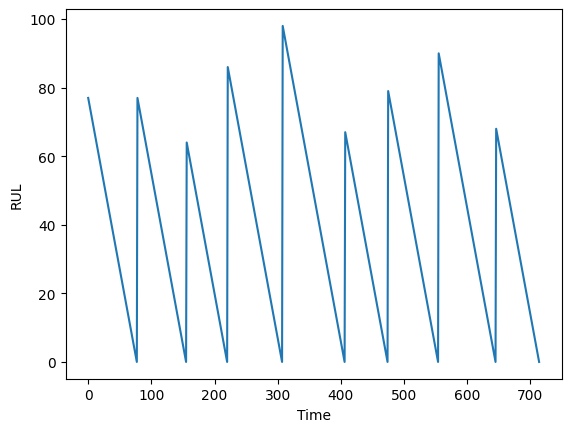

In [99]:
# plot x_train and y_train
plt.plot(y_train_for_RUL)
plt.ylabel('RUL')
plt.xlabel('Time')
plt.show()


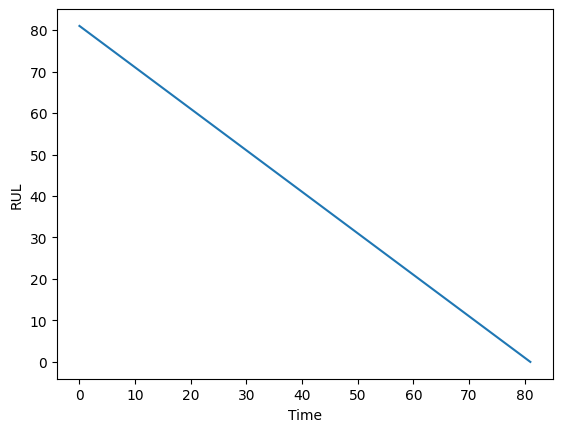

In [100]:
# plot x_test and y_test
plt.plot(y_test_for_RUL)
plt.ylabel('RUL')
plt.xlabel('Time')
plt.show()


In [101]:
# Save Dataframes to CSV
X_train_for_RUL.to_csv('X_train_for_RUL_DS006.csv', index = False)
y_train_for_RUL.to_csv('y_for_RUL_DS006.csv', index = False)
X_test_for_RUL.to_csv('X_test_for_RUL_DS006.csv', index = False)
y_test_for_RUL.to_csv('y_test_for_RUL_DS006.csv', index = False)

In [102]:
lets_for_x = pd.read_csv('X_train_for_RUL_DS006.csv')
lets_for_x.describe()

,alt,Mach,TRA,T2,unit,cycle,Fc,hs,RUL,T48,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
count,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,...,715.0,715.0,715.000000,715.000000,715.000000,715.000000,715.0,715.0,715.0,715.0
mean,18667.648252,0.589308,70.614206,506.226716,5.019580,40.939860,1.913287,0.292308,39.939860,1718.008767,...,0.0,0.0,-0.005714,-0.006799,-0.003631,-0.005787,0.0,0.0,0.0,0.0
std,6640.644675,0.078648,8.316597,7.054843,2.540354,24.185801,0.825558,0.455141,24.185801,47.421877,...,0.0,0.0,0.011611,0.014627,0.004411,0.009611,0.0,0.0,0.0,0.0
min,10016.000000,0.438527,54.931248,483.240022,1.000000,1.000000,1.000000,0.000000,0.000000,1622.934563,...,0.0,0.0,-0.123330,-0.150073,-0.023245,-0.068299,0.0,0.0,0.0,0.0
25%,12058.500000,0.528854,61.171440,502.590888,3.000000,20.000000,1.000000,0.000000,19.000000,1683.201967,...,0.0,0.0,-0.005427,-0.005840,-0.004583,-0.006056,0.0,0.0,0.0,0.0
50%,19355.250000,0.580844,72.597137,506.810113,5.000000,40.000000,2.000000,0.000000,39.000000,1707.658598,...,0.0,0.0,-0.001843,-0.001947,-0.001641,-0.001991,0.0,0.0,0.0,0.0
75%,23990.000000,0.649656,77.958427,511.101330,7.000000,60.000000,3.000000,1.000000,59.000000,1752.756003,...,0.0,0.0,-0.001065,-0.000935,-0.000943,-0.001093,0.0,0.0,0.0,0.0
max,32978.000000,0.734958,84.022842,518.438422,9.000000,99.000000,3.000000,1.000000,98.000000,1837.233852,...,0.0,0.0,-0.000168,-0.000134,-0.000112,-0.000205,0.0,0.0,0.0,0.0


In [103]:
lets_y = pd.read_csv('y_for_RUL_DS006.csv')
lets_y.describe()

,RUL
count,715.000000
mean,39.939860
std,24.185801
min,0.000000
25%,19.000000
50%,39.000000
75%,59.000000
max,98.000000


In [104]:
has_nan = X_test_for_RUL.isna().any().any()
print(f"Does the DataFrame have NaN values? {has_nan}")

Does the DataFrame have NaN values? False


In [105]:
X_test_for_RUL

,alt,Mach,TRA,T2,unit,cycle,Fc,hs,RUL,T48,...,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,13260.00,0.522081,61.171440,506.446042,10.0,1.0,1.0,1.0,81.0,1668.405323,...,0.0,0.0,-0.000381,-0.000732,-0.001015,-0.000888,0.0,0.0,0.0,0.0
1,10923.00,0.465255,69.696770,517.724237,10.0,2.0,1.0,1.0,80.0,1802.155568,...,0.0,0.0,-0.000366,-0.000748,-0.001000,-0.000905,0.0,0.0,0.0,0.0
2,10251.25,0.465444,59.940979,515.303818,10.0,3.0,1.0,1.0,79.0,1687.055543,...,0.0,0.0,-0.000357,-0.000768,-0.000991,-0.000918,0.0,0.0,0.0,0.0
3,13209.75,0.567992,71.454567,512.004311,10.0,4.0,1.0,1.0,78.0,1793.881393,...,0.0,0.0,-0.000354,-0.000790,-0.000988,-0.000929,0.0,0.0,0.0,0.0
4,13209.75,0.567992,71.454567,512.004311,10.0,5.0,1.0,1.0,77.0,1793.953118,...,0.0,0.0,-0.000356,-0.000815,-0.000990,-0.000937,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,13500.00,0.532618,72.948700,512.283731,10.0,78.0,1.0,0.0,4.0,1824.635108,...,0.0,0.0,-0.015818,-0.010397,-0.015885,-0.018358,0.0,0.0,0.0,0.0
78,10251.25,0.465444,59.940979,515.303818,10.0,79.0,1.0,0.0,3.0,1715.784897,...,0.0,0.0,-0.017059,-0.010997,-0.017152,-0.019810,0.0,0.0,0.0,0.0
79,10923.00,0.465255,69.696770,517.724237,10.0,80.0,1.0,0.0,2.0,1836.036087,...,0.0,0.0,-0.018363,-0.011644,-0.018498,-0.021349,0.0,0.0,0.0,0.0
80,12727.00,0.535390,59.149971,509.515173,10.0,81.0,1.0,0.0,1.0,1696.180975,...,0.0,0.0,-0.019724,-0.012340,-0.019921,-0.022971,0.0,0.0,0.0,0.0
